In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [8]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [9]:
%%time
path_figs = './figs/exp2/200kstd5/'
Path(path_figs).mkdir(exist_ok = True, parents = True)
N,D = 2*10**5, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class2', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [1, std], [1, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:441, Number of Points:200000
CPU times: user 182 ms, sys: 75.1 ms, total: 257 ms
Wall time: 279 ms


In [10]:
data

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688
2,0.423655,0.645894,1,0,2.037892,-4.108543,-6.146435
3,0.437587,0.891773,0,1,3.038081,-3.791558,6.829639
4,0.963663,0.383442,0,0,-6.136829,3.079311,9.216140
...,...,...,...,...,...,...,...
199995,0.811490,0.532533,0,1,-7.877269,-0.912863,-6.964406
199996,0.824813,0.706098,0,0,5.751925,6.230608,0.478683
199997,0.001283,0.010608,0,1,1.743823,4.350759,-2.606936
199998,0.077228,0.831937,1,0,-4.299568,2.181769,6.481338


In [11]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.499785,0.499334,0.370380,0.501805,0.811022,0.823083,0.371024
std,0.288533,0.289177,0.482908,0.499998,5.019752,5.011775,7.076320
min,0.000003,0.000003,0.000000,0.000000,-24.011493,-21.876708,-33.880283
25%,0.249671,0.247699,0.000000,0.000000,-2.575307,-2.560167,-4.388602
50%,0.501024,0.498865,0.000000,1.000000,0.834033,0.818483,0.383120
75%,0.749132,0.750450,1.000000,1.000000,4.208105,4.199234,5.107633
max,0.999990,0.999999,1.000000,1.000000,22.920856,24.583311,36.692658


In [12]:
#mpl.style.use(['seaborn-paper'])
#mpl.rcParams.update(mpl.rcParamsDefault)


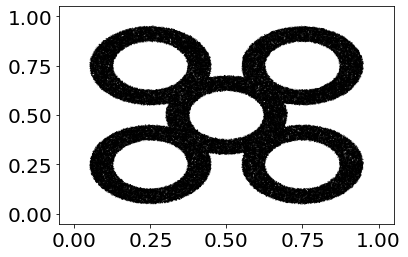

In [13]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [14]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 5min 24s, sys: 176 ms, total: 5min 25s
Wall time: 5min 25s


In [15]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413,0,1.250307,-4.418518
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688,0,2.951782,0.663732
2,0.423655,0.645894,1,0,2.037892,-4.108543,-6.146435,0,3.794853,1.756961
3,0.437587,0.891773,0,1,3.038081,-3.791558,6.829639,0,0.828943,2.209138
4,0.963663,0.383442,0,0,-6.136829,3.079311,9.216140,0,0.167302,6.304131


### Model performance

In [16]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C                                                  
0         0  1.009590  1.000124  1.001044 -0.009465 -0.008546
          1 -0.029854  1.021937  0.980984  1.051791  1.010837
1         0  1.002319  1.014057  0.898211 -0.011739  0.104108
          1  0.987789 -0.000052  0.113158  0.987841  0.874632

### Apply clustering 

In [17]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 2h 6min 7s, sys: 29.9 s, total: 2h 6min 37s
Wall time: 3min 30s


In [18]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413,0,1.250307,-4.418518,326,418
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688,0,2.951782,0.663732,243,384
2,0.423655,0.645894,1,0,2.037892,-4.108543,-6.146435,0,3.794853,1.756961,281,430
3,0.437587,0.891773,0,1,3.038081,-3.791558,6.829639,0,0.828943,2.209138,387,61
4,0.963663,0.383442,0,0,-6.136829,3.079311,9.216140,0,0.167302,6.304131,188,437


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [19]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [20]:
box

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.517013,491.0,1.0,0.002455
1,1,0.148158,450.0,1.0,0.002250
2,2,-0.008608,450.0,1.0,0.002250
3,3,0.457971,431.0,1.0,0.002155
4,4,-0.048337,419.0,1.0,0.002095
...,...,...,...,...,...
436,436,-0.048136,469.0,1.0,0.002345
437,437,-0.065902,465.0,1.0,0.002325
438,438,0.296048,433.0,1.0,0.002165
439,439,0.048762,459.0,1.0,0.002295


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


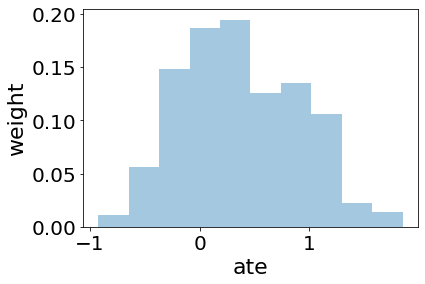

In [21]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 10
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, hist_kws = {'weights':box['Box-Weights'].values} , bins=bins, kde = False,ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


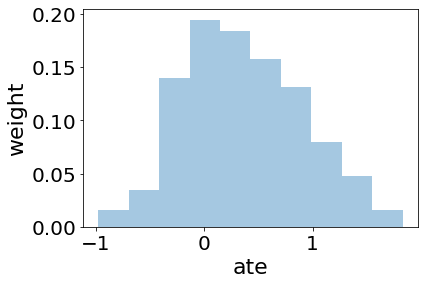

In [22]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], hist_kws={'weights':kmeans['Kmeans-Weights'].values},
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


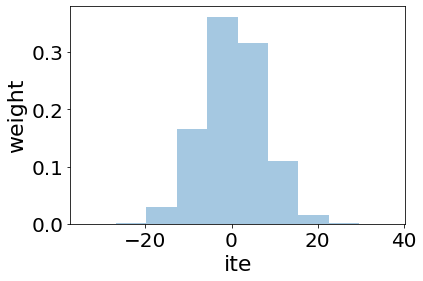

In [23]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = bins,hist_kws={'weights': np.ones(len(data))/len(data)},
                  kde = kde, ax = ax)
ax.set_xlabel('ite')
ax.set_ylabel('weight')
fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [24]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,441.00000,441.000000,441.000000,441.000000,441.000000
mean,220.00000,0.372286,453.514739,0.902324,0.002268
std,127.44999,0.540958,21.551110,0.144657,0.000108
min,0.00000,-0.925256,399.000000,0.505938,0.001995
25%,110.00000,-0.048136,439.000000,0.828947,0.002195
50%,220.00000,0.340929,453.000000,1.000000,0.002265
75%,330.00000,0.791985,468.000000,1.000000,0.002340
max,440.00000,1.853446,520.000000,1.000000,0.002600


### Calculate ATT per Cluster not known Model Calculated CF

In [25]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


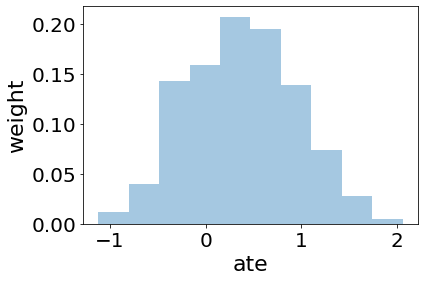

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'], hist_kws={'weights':box2['Box-Weights'].values},bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


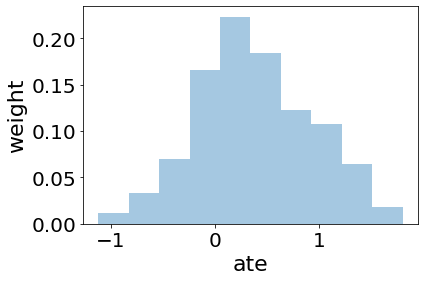

In [27]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], hist_kws={'weights':kmeans2['Kmeans-Weights'].values},
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


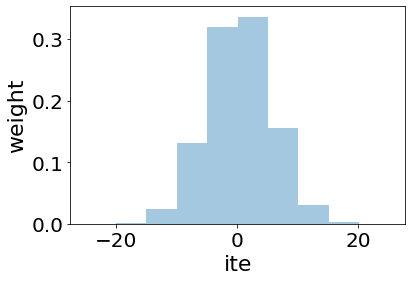

In [28]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax, hist_kws={'weights': np.ones(len(data))/len(data)})

ax.set_xlabel('ite')
ax.set_ylabel('weight')
fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Weighted Kmeans 2-Clustering

In [29]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names2 = ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

for dd, name, name2,w in zip(all_data, names, names2,weights):
    kmeans_clustering(dd, clusters = 2, col_select = [name2], 
                      cluster_name = name, fit_kwargs={'sample_weight':dd[w].values} )

CPU times: user 211 ms, sys: 4 ms, total: 215 ms
Wall time: 109 ms


In [30]:
data2 = data.copy()

In [31]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413,0,1.250307,-4.418518,326,418
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688,0,2.951782,0.663732,243,384


### 2 Clustering in the ITEs

In [32]:
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CTrue',col_select = ['ITE'] )
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CGDBR',col_select = ['ITE-GDBR'] )

### Clustering for Drawing 
1. Apply Box clustering to separate the space in K clusters
2. Group by this clusters and get the Average C2-Avg from the 2 clustering
3. Color each box with the C2-Avg corresponding to each box

In [33]:
K = 10**4
data2,_ = box_clustering(data2, clusters = K, cluster_name = 'C2-Avg', col_select = col_select)

In [34]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413,0,1.250307,-4.418518,326,418,0,0,7154
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688,0,2.951782,0.663732,243,384,1,1,5460


In [35]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.517013,491.0,1.0,0.002455,0
1,1,0.148158,450.0,1.0,0.002250,0


### Merge 2 Clustering with initial data

In [36]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

### Find Average 2 Clustering per draw cluster and merge them in the initial dataset

In [37]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2',
            #    'Agglo2-Cl2','ITE-CTrue', 'ITE-CGDBR']
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 
               'Kmeans2-Cl2','ITE-CTrue', 'ITE-CGDBR']

avg_c = data2.groupby('C2-Avg', sort = True)[class_names].mean().reset_index()
data2 = data2.merge(avg_c, on = 'C2-Avg', how = 'left', suffixes=("","y"))

In [38]:
avg_c.head()

,C2-Avg,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,ITE-CTrue,ITE-CGDBR
0,0,0.0,0.0,0.0,0.0,0.333333,0.285714
1,1,0.0,0.0,0.0,0.0,0.380952,0.571429
2,2,0.0,0.0,0.0,0.0,0.400000,0.500000
3,3,0.0,0.0,0.0,0.0,0.263158,0.368421
4,4,0.0,0.0,0.0,0.0,0.451613,0.225806


In [39]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2y,Kmeans-Cl2y,Box2-Cl2y,Kmeans2-Cl2y,ITE-CTruey,ITE-CGDBRy
0,0.548814,0.715189,0,0,5.668825,-0.227588,-5.896413,0,1.250307,-4.418518,326,418,0,0,7154,0,0,1,0,0.0,0.0,1.0,0.0,0.526316,0.578947
1,0.602763,0.544883,0,1,3.615514,-4.550173,8.165688,0,2.951782,0.663732,243,384,1,1,5460,0,0,0,0,0.0,0.0,0.0,0.0,0.588235,0.588235


### Plot reconstruction of data

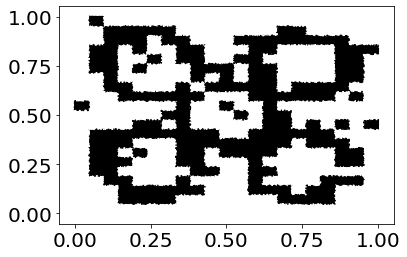

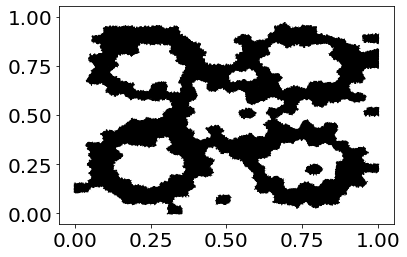

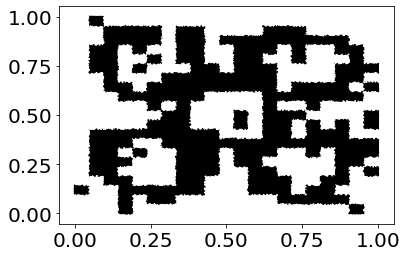

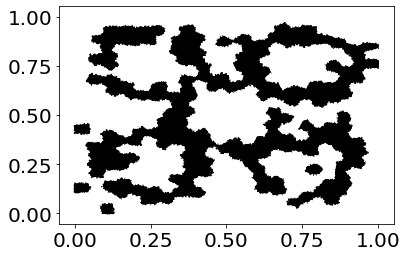

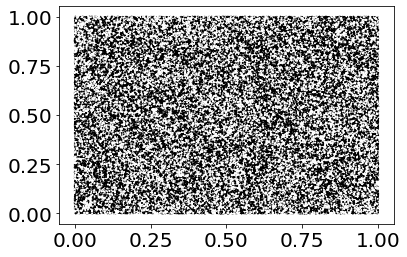

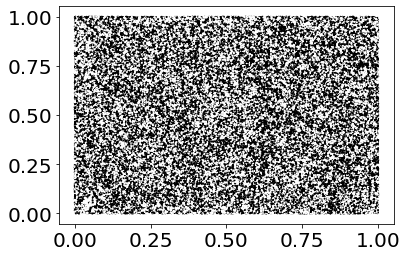

CPU times: user 58 s, sys: 1.72 s, total: 59.7 s
Wall time: 58 s


In [40]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']


path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
class_names2 = [name+'y' for name in class_names]
use_poly = False
for name in class_names:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

### Plot same as above but with box averaging

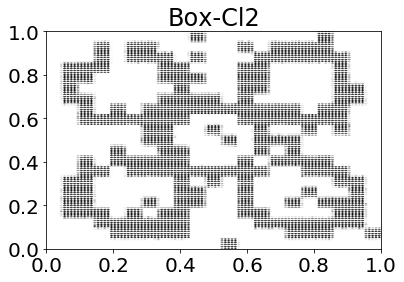

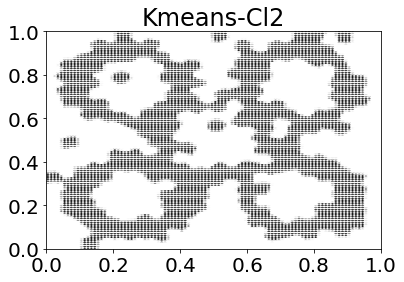

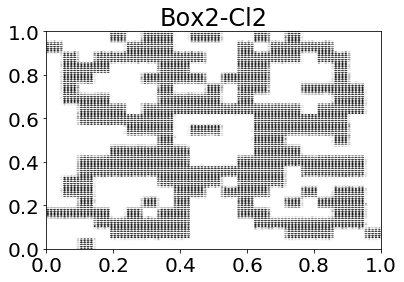

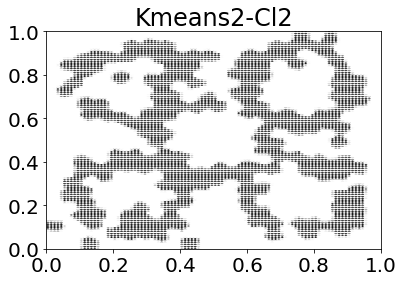

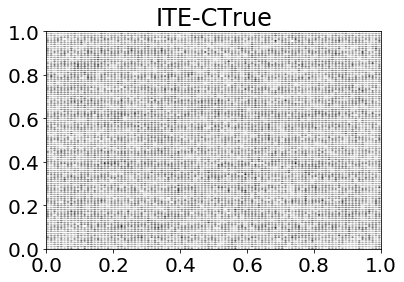

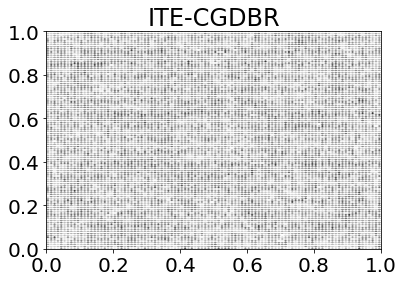

CPU times: user 3.24 s, sys: 79 ms, total: 3.32 s
Wall time: 3.31 s


In [41]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']



class_names2 = [name+'y' for name in class_names]
use_poly = True
for name in class_names:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 0.25)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
       # ax.figure.colorbar(coll)
    ax.set_title(name)
    #fig.colorbar(sc)

    plt.show()
    

### homogeneity experiment

clusters = [4, 16, 25, 100]
clustering_algo = ['box_clustering', 'kmeans_clustering', 'agglomerative_clustering']

result = get_homogeneity(data.copy(),clusters = clusters, clustering_algo = clustering_algo, col_select = col_select)

pd.DataFrame(result)